# Passing Neutrino
## Azimuth and Zenith prediction based on Neural Networks

We create models for azimuth and zenith prediction (The details and results were described in the report)

In [1]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor 

from tensorflow.keras import Sequential

from keras import Model
from keras.layers import Input, Conv1D, Dense, Masking,Concatenate,Dropout,LSTM
from keras.activations import leaky_relu
from keras.optimizers import Adamax
from keras.mixed_precision import LossScaleOptimizer
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


###### Loading datasets without split



In [2]:
time = pd.read_parquet('01_Datasets/Sensor-timeINPUT_Norm.parquet')
charge = pd.read_parquet('01_Datasets/Sensor-chargeINPUT_Norm.parquet')
target = pd.read_parquet('01_Datasets/Target_Norm.parquet')

###### Split datasets in train set and test set

In [3]:
#To limit the use of memory and since the y’s are the same for charge and time, then they only take one time from the split.
X_trainTIME, X_testTIME, _ , _ = train_test_split(time,target, test_size=0.2) 

In [4]:
X_trainCHARGE, X_testCHARGE, y_train, y_test = train_test_split(charge,target, test_size=0.2)

In [5]:
X_trainTIME.to_parquet('02_Split/XT_time.parquet')
X_testTIME.to_parquet('02_Split/XTe_time.parquet')
X_trainCHARGE.to_parquet('02_Split/XT_charge.parquet')
X_testCHARGE.to_parquet('02_Split/XTe_charge.parquet')
y_train.to_parquet('02_Split/y_train.parquet')
y_test.to_parquet('02_Split/y_test.parquet')

###### Loading of the split dataset

In [ ]:
X_trainTIME = pd.read_parquet('02_Split/XT_time.parquet')
X_trainCHARGE = pd.read_parquet('02_Split/XT_charge.parquet')
y_train = pd.read_parquet('02_Split/y_train.parquet')

In [ ]:
X_testTIME = pd.read_parquet('02_Split/XTe_time.parquet')
X_testCHARGE = pd.read_parquet('02_Split/XTe_charge.parquet')
y_test = pd.read_parquet('02_Split/y_test.parquet')

##### Definition of useful functions
###### Function to calculate MEAN ANGULAR ERROR for the evaluation of models, proposal and taken by Kaggle

In [ ]:
def angular_dist_score(y_train,y_predict):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    y_pre = pd.DataFrame(y_predict, columns=['azimuth', 'zenith'])
    
    az_true = y_train['azimuth'].to_numpy()
    zen_true = y_train['zenith'].to_numpy()
    az_pred = y_pre['azimuth'].to_numpy()
    zen_pred = y_pre['zenith'].to_numpy()
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)

    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

###### Function for visualization of the graphs of trend of the fit of the models

In [ ]:
def get_plot(historyOfFit):
    plt.plot(historyOfFit.history['loss'], label='Train Loss')
    plt.plot(historyOfFit.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Phase 1: Predict Azimuth And Zenith Using Only The Nanoseconds Of Activation

#### SGD Regressor

In [ ]:
sgd_regressor1 = SGDRegressor(max_iter=1000, alpha=0.0001, learning_rate='optimal',verbose=2)
azimuthSGD = sgd_regressor1.fit(X_trainTIME, y_train['azimuth']) 

sgd_regressor2 = SGDRegressor(max_iter=1000, alpha=0.0001, learning_rate='optimal',verbose=2)
zenithSGD = sgd_regressor2.fit(X_trainTIME, y_train['zenith']) 

In [12]:
y_az = pd.DataFrame(azimuthSGD.predict(X_testTIME),columns=["azimuth"])
y_zen = pd.DataFrame(zenithSGD.predict(X_testTIME),columns=["zenith"])

y_predSGD = pd.concat([y_az, y_zen], axis=1)
y_predSGD

,azimuth,zenith
0,-9.801129e+04,108248.031376
1,3.097471e+04,-151690.476437
2,6.228161e+05,-26726.663937
3,6.315575e+05,-154992.242062
4,5.305202e+05,-177607.335812
...,...,...
59995,1.969036e+05,-33217.316280
59996,-2.295743e+06,814781.851688
59997,-5.188696e+05,-326937.023312
59998,3.744976e+05,357541.914188


In [14]:
angular_dist_score(y_test,y_predSGD)

1.5705498294436486

Saving the weights of the model

In [16]:
with open('03_Weights/SGDRegressor_Azimuth.pkl','wb') as f:
    pickle.dump(azimuthSGD,f)

with open('03_Weights/SGDRegressor_Zenith.pkl','wb') as f:
    pickle.dump(zenithSGD,f)

#### Neural Networks
###### Dense Layer-Based Neural Network

In [5]:
def denseModel_TIME():
    model = Sequential()
    
    model.add(Masking(mask_value=0,input_shape=(5160,)))
    model.add(Dense(units=2024, activation=leaky_relu,use_bias=True, dtype='float32'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=1024, activation=leaky_relu,use_bias=True, dtype='float32'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=512, activation=leaky_relu,use_bias=True, dtype='float32'))
    model.add(Dropout(0.3))

    model.add(Dense(units= 256, activation=leaky_relu, dtype='float32'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units = 128, activation=leaky_relu, dtype='float32'))
    model.add(Dropout(0.2))

    model.add(Dense(units=64, activation=leaky_relu, dtype='float32'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=32, activation=leaky_relu, dtype='float32'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=2,activation=leaky_relu,dtype='float32'))
    
    model.compile(optimizer=LossScaleOptimizer(Adamax(learning_rate=0.001)), loss= 'mean_squared_error')
    
    return model

model = denseModel_TIME()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 5160)              0         
                                                                 
 dense (Dense)               (None, 2024)              10445864  
                                                                 
 dropout (Dropout)           (None, 2024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2073600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [6]:
callback = EarlyStopping (monitor='val_loss',patience=2, verbose=1)
history = model.fit(X_trainTIME,y_train,epochs=20,validation_split=0.2,batch_size=16,callbacks=callback)

Epoch 1/20
12000/12000 [==============================] - 1084s 90ms/step - loss: 0.0680 - val_loss: 0.0659
Epoch 2/20
12000/12000 [==============================] - 1074s 89ms/step - loss: 0.0661 - val_loss: 0.0660
Epoch 3/20
12000/12000 [==============================] - 1037s 86ms/step - loss: 0.0659 - val_loss: 0.0660
Epoch 3: early stopping


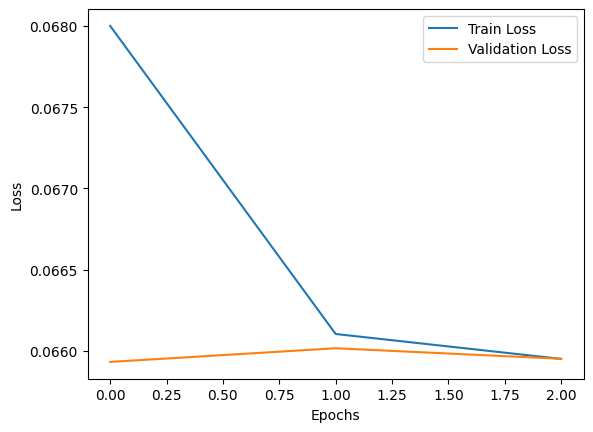

In [7]:
get_plot(history)

In [8]:
##Save the weight
model.save_weights('03_Weights/denseModel_TIME.weights.h5', overwrite=True)

In [9]:
y_Pred_denseModel_TIME = model.predict(X_testTIME)

1875/1875 [==============================] - 28s 15ms/step


In [10]:
angular_dist_score(y_test,y_Pred_denseModel_TIME)

0.2340966

######  LSTM Layer-Based Neural Network

In [21]:
def lstm_model():
    model = Sequential()
    
    model.add(Masking(mask_value=0,input_shape=(None,5160)))
    model.add(Dense(units=2024, activation=leaky_relu,use_bias=True, dtype='float32'))
    model.add(Dropout(0.3))
    
    model.add(LSTM(1024,dropout=0.3,activation=leaky_relu, return_sequences=True, dtype='float32'))
   
    model.add(Dense(units=512, activation=leaky_relu,use_bias=True, dtype='float32'))
    model.add(Dropout(0.3))

    model.add(LSTM(256,dropout=0.2,activation=leaky_relu,return_sequences=True, dtype='float32'))
   
    model.add(Dense(units = 128, activation=leaky_relu, dtype='float32'))
    model.add(Dropout(0.2))

    model.add(Dense(units=2,activation=leaky_relu,dtype='float32'))
    
    model.compile(optimizer=LossScaleOptimizer(Adamax(learning_rate=0.001)), loss= 'mean_squared_error')
    
    return model

In [22]:
model_lstm = lstm_model()
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, None, 5160)        0         
                                                                 
 dense_13 (Dense)            (None, None, 2024)        10445864  
                                                                 
 dropout_11 (Dropout)        (None, None, 2024)        0         
                                                                 
 lstm_2 (LSTM)               (None, None, 1024)        12488704  
                                                                 
 dense_14 (Dense)            (None, None, 512)         524800    
                                                                 
 dropout_12 (Dropout)        (None, None, 512)         0         
                                                                 
 lstm_3 (LSTM)               (None, None, 256)        

In [ ]:
X_trainTIME = X_trainTIME.to_numpy()
X_trainTIME = X_trainTIME.reshape((X_trainTIME.shape[0], 1, X_trainTIME.shape[1]))

In [26]:
history = model_lstm.fit(X_trainTIME,y_train,epochs=20,validation_split=0.2,batch_size=8, callbacks= EarlyStopping (monitor='val_loss',patience=2, verbose=1))

Epoch 1/20
24000/24000 [==============================] - 4129s 172ms/step - loss: 0.0667 - val_loss: 0.0661
Epoch 2/20
24000/24000 [==============================] - 3968s 165ms/step - loss: 0.0661 - val_loss: 0.0660
Epoch 3/20
24000/24000 [==============================] - 3915s 163ms/step - loss: 0.0660 - val_loss: 0.0659
Epoch 4/20
24000/24000 [==============================] - 4048s 169ms/step - loss: 0.0660 - val_loss: 0.0660
Epoch 5/20
24000/24000 [==============================] - 3995s 166ms/step - loss: 0.0659 - val_loss: 0.0660
Epoch 5: early stopping


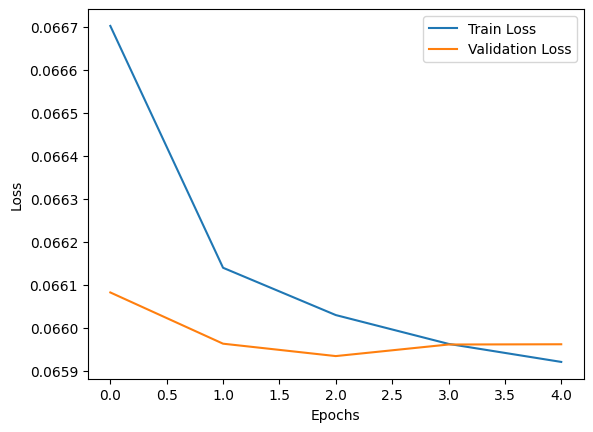

In [29]:
get_plot(history)

The model learns well until the third epoch, then begins not to generalize more well and to overfitting.

In [32]:
#Save weights model
model_lstm.save_weights('03_Weights/model_TimeLSTM.weights.h5', overwrite=True)

In [34]:
X_testTIME = X_testTIME.to_numpy()
X_testTIME = X_testTIME.reshape((X_testTIME.shape[0], 1, X_testTIME.shape[1]))

y_PREDlstm_model = model_lstm.predict(X_testTIME)

1875/1875 [==============================] - 60s 32ms/step


In [36]:
y_PREDlstm_model = y_PREDlstm_model.reshape((y_PREDlstm_model.shape[0], y_PREDlstm_model.shape[2]))
y_pre = pd.DataFrame(y_PREDlstm_model, columns=['azimuth', 'zenith'])

angular_dist_score(y_test,y_PREDlstm_model)

0.23334724

## Phase 2: Predicting Azimuth and Zenith Using The Nanoseconds Of Activation and Detected Charge

#### Neural Networks
###### 1D Convolutional Layer-Based Neural Network 

In [5]:
def conv_plus_lstm():
    
    input_times = Input(shape=(None,5160), name='input_times')
    input_charges = Input(shape=(None,5160), name='input_charges')

    masked_times = Masking(mask_value=0.0)(input_times)
    masked_charges = Masking(mask_value=0.0)(input_charges)

    conv_times_1 = Conv1D(filters=64, kernel_size=3, activation=leaky_relu, padding='same')(masked_times)
    conv_times_2 = Conv1D(filters=128, kernel_size=3, activation=leaky_relu, padding='same')(conv_times_1)

    conv_charges_1 = Conv1D(filters=64, kernel_size=3, activation=leaky_relu, padding='same')(masked_charges)
    conv_charges_2 = Conv1D(filters=128, kernel_size=3, activation=leaky_relu, padding='same')(conv_charges_1)

    concatenated = Concatenate()([conv_times_2, conv_charges_2])

    lstm_1 = LSTM(128, return_sequences=True)(concatenated)
    lstm_2 = LSTM(128)(lstm_1)

    dense_1 = Dense(64, activation='relu')(lstm_2)
    dropout = Dropout(0.5)(dense_1)
    output_layer = Dense(2, name='output')(dropout) 

    model = Model(inputs=[input_times, input_charges], outputs=output_layer)

    model.compile(optimizer=LossScaleOptimizer(Adamax(learning_rate=0.001)), loss= 'mean_squared_error')

    return model

In [6]:
model_conv = conv_plus_lstm()
model_conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_times (InputLayer)       [(None, None, 5160)  0           []                               
                                ]                                                                 
                                                                                                  
 input_charges (InputLayer)     [(None, None, 5160)  0           []                               
                                ]                                                                 
                                                                                                  
 masking (Masking)              (None, None, 5160)   0           ['input_times[0][0]']            
                                                                                              

In [7]:
X_trainTIME = X_trainTIME.to_numpy()
X_trainTIME = X_trainTIME.reshape((X_trainTIME.shape[0], 1, X_trainTIME.shape[1]))

X_trainCHARGE = X_trainCHARGE.to_numpy()
X_trainCHARGE = X_trainCHARGE.reshape((X_trainCHARGE.shape[0], 1, X_trainCHARGE.shape[1]))

In [8]:
callback = EarlyStopping (monitor='val_loss',patience=3, verbose=1)

history = model_conv.fit([X_trainTIME, X_trainCHARGE], y_train, 
                        epochs=20,batch_size=8, 
                        validation_split=0.2,callbacks=callback)

Epoch 1/20
24000/24000 [==============================] - 658s 27ms/step - loss: 0.0675 - val_loss: 0.0659
Epoch 2/20
24000/24000 [==============================] - 527s 22ms/step - loss: 0.0658 - val_loss: 0.0658
Epoch 3/20
24000/24000 [==============================] - 481s 20ms/step - loss: 0.0657 - val_loss: 0.0659
Epoch 4/20
24000/24000 [==============================] - 472s 20ms/step - loss: 0.0655 - val_loss: 0.0659
Epoch 5/20
24000/24000 [==============================] - 485s 20ms/step - loss: 0.0653 - val_loss: 0.0660
Epoch 5: early stopping


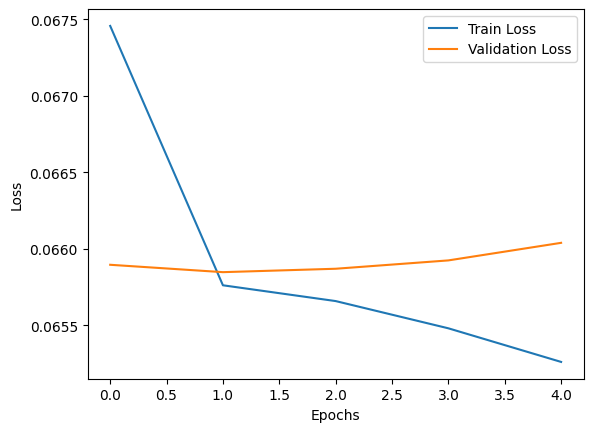

In [9]:
get_plot(history)

The model learns well until the first epoch, then begins not to generalize more well and to overfitting.

In [10]:
model_conv.save_weights('03_Weights/conv_plus_lstm.weights.h5', overwrite=True)

In [17]:
X_testTIME = X_testTIME.to_numpy()
X_testTIME = X_testTIME.reshape((X_testTIME.shape[0], 1, X_testTIME.shape[1]))

X_testCHARGE = X_testCHARGE.to_numpy()
X_testCHARGE = X_testCHARGE.reshape((X_testCHARGE.shape[0], 1, X_testCHARGE.shape[1]))

y_pred_conv_plus_lstm = model_conv.predict([X_testTIME, X_testCHARGE])

1875/1875 [==============================] - 13s 6ms/step


In [37]:
y_pred_conv_plus_lstm = y_pred_conv_plus_lstm.reshape((y_pred_conv_plus_lstm.shape[0], y_pred_conv_plus_lstm.shape[1]))
y_pre = pd.DataFrame(y_pred_conv_plus_lstm, columns=['azimuth', 'zenith'])

angular_dist_score(y_test,y_pred_conv_plus_lstm)

0.23352784

###### 1D Convolutional Layer-Only Neural Network:

In [25]:
def just_conv():
    
    input_times = Input(shape=(None,5160), name='input_times')
    input_charges = Input(shape=(None,5160), name='input_charges')

    masked_times = Masking(mask_value=0.0)(input_times)
    masked_charges = Masking(mask_value=0.0)(input_charges)

    conv_times_1 = Conv1D(filters=64, kernel_size=5, activation=leaky_relu, padding='same')(masked_times)
    conv_times_2 = Conv1D(filters=128, kernel_size=5, activation=leaky_relu, padding='same')(conv_times_1)

    conv_charges_1 = Conv1D(filters=64, kernel_size=5, activation=leaky_relu, padding='same')(masked_charges)
    conv_charges_2 = Conv1D(filters=128, kernel_size=5, activation=leaky_relu, padding='same')(conv_charges_1)

    concatenated = Concatenate()([conv_times_2, conv_charges_2])
    
    conv_charges_3 = Conv1D(filters=32, kernel_size=3, activation=leaky_relu, padding='same')(concatenated)
    
    output_layer = Dense(2, name='output')(conv_charges_3)  

    model = Model(inputs=[input_times, input_charges], outputs=output_layer)

    model.compile(optimizer=LossScaleOptimizer(Adamax(learning_rate=0.001)), loss= 'mean_squared_error')

    return model

In [26]:
model_justConv = just_conv()
model_justConv.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_times (InputLayer)       [(None, None, 5160)  0           []                               
                                ]                                                                 
                                                                                                  
 input_charges (InputLayer)     [(None, None, 5160)  0           []                               
                                ]                                                                 
                                                                                                  
 masking_2 (Masking)            (None, None, 5160)   0           ['input_times[0][0]']            
                                                                                            

In [27]:
callback = EarlyStopping (monitor='val_loss',patience=3, verbose=1)

history = model_justConv.fit([X_trainTIME, X_trainCHARGE], y_train, 
                        epochs=20,batch_size=8, 
                        validation_split=0.2,callbacks=callback)

Epoch 1/20
24000/24000 [==============================] - 702s 29ms/step - loss: 0.0664 - val_loss: 0.0660
Epoch 2/20
24000/24000 [==============================] - 658s 27ms/step - loss: 0.0660 - val_loss: 0.0660
Epoch 3/20
24000/24000 [==============================] - 646s 27ms/step - loss: 0.0659 - val_loss: 0.0660
Epoch 4/20
24000/24000 [==============================] - 717s 30ms/step - loss: 0.0659 - val_loss: 0.0660
Epoch 5/20
24000/24000 [==============================] - 658s 27ms/step - loss: 0.0659 - val_loss: 0.0661
Epoch 5: early stopping


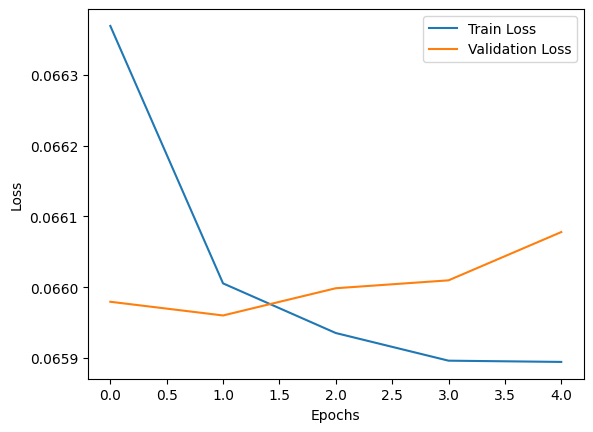

In [28]:
get_plot(history)

The model learns well until the first epoch, then begins not to generalize more well and to overfitting.

In [30]:
model_justConv.save_weights('03_Weights/just_conv.weights.h5', overwrite=True)

In [40]:
y_pred_just_conv = model_justConv.predict([X_testTIME, X_testCHARGE])

1875/1875 [==============================] - 9s 5ms/step


In [42]:
y_pred_just_conv = y_pred_just_conv.reshape((y_pred_just_conv.shape[0],y_pred_just_conv.shape[2]))
y_pre = pd.DataFrame(y_pred_just_conv, columns=['azimuth', 'zenith'])

angular_dist_score(y_test,y_pred_just_conv)

0.23548542

###### LSTM-Only Neural Network:

In [4]:
def deep_lstm_model():
    input_times = Input(shape=(None, 5160), name='input_times')
    input_charges = Input(shape=(None, 5160), name='input_charges')

    masked_times = Masking(mask_value=0)(input_times)
    dense_times_1 = Dense(units=2024, activation=leaky_relu, use_bias=True, dtype='float32')(masked_times)
    dropout_times_1 = Dropout(0.3)(dense_times_1)
    
    lstm_times_1 = LSTM(1024, dropout=0.3, activation=leaky_relu, return_sequences=True, dtype='float32')(dropout_times_1)
    dense_times_2 = Dense(units=512, activation= leaky_relu, use_bias=True, dtype='float32')(lstm_times_1)
    dropout_times_2 = Dropout(0.3)(dense_times_2)
    
    lstm_times_2 = LSTM(256, dropout=0.2, activation=leaky_relu, return_sequences=True, dtype='float32')(dropout_times_2)
    dense_times_3 = Dense(units=128, activation=leaky_relu, dtype='float32')(lstm_times_2)
    dropout_times_3 = Dropout(0.2)(dense_times_3)
    
    outputTime = Dense(units=64, activation=leaky_relu, dtype='float32')(dropout_times_3)

    masked_charge = Masking(mask_value=0)(input_charges)
    dense_charges_1 = Dense(units=2024, activation=leaky_relu, use_bias=True, dtype='float32')(masked_charge)
    dropout_charges_1 = Dropout(0.3)(dense_charges_1)
    
    lstm_charges_1 = LSTM(1024, dropout=0.3, activation=leaky_relu, return_sequences=True, dtype='float32')(dropout_charges_1)
    dense_charges_2 = Dense(units=512, activation= leaky_relu, use_bias=True, dtype='float32')(lstm_charges_1)
    dropout_charges_2 = Dropout(0.3)(dense_charges_2)
    
    lstm_charges_2 = LSTM(256, dropout=0.2, activation=leaky_relu, return_sequences=True, dtype='float32')(dropout_charges_2)
    dense_charges_3 = Dense(units=128, activation=leaky_relu, dtype='float32')(lstm_charges_2)
    dropout_charges_3 = Dropout(0.2)(dense_charges_3)
    
    outputCharge = Dense(units=64, activation=leaky_relu, dtype='float32')(dropout_charges_3)
  
    concatenated = Concatenate()([outputTime, outputCharge])

    output_layer = Dense(units=2, activation=leaky_relu, dtype='float32')(concatenated)

    model = Model(inputs=[input_times, input_charges], outputs=output_layer)

    model.compile(optimizer=LossScaleOptimizer(Adamax(learning_rate=0.001)), loss='mean_squared_error')
    
    return model

In [5]:
model_deep_lstm = deep_lstm_model()
model_deep_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_times (InputLayer)       [(None, None, 5160)  0           []                               
                                ]                                                                 
                                                                                                  
 input_charges (InputLayer)     [(None, None, 5160)  0           []                               
                                ]                                                                 
                                                                                                  
 masking (Masking)              (None, None, 5160)   0           ['input_times[0][0]']            
                                                                                              

In [6]:
X_trainTIME = X_trainTIME.to_numpy()
X_trainTIME = X_trainTIME.reshape((X_trainTIME.shape[0], 1, X_trainTIME.shape[1]))

X_trainCHARGE = X_trainCHARGE.to_numpy()
X_trainCHARGE = X_trainCHARGE.reshape((X_trainCHARGE.shape[0], 1, X_trainCHARGE.shape[1]))

In [7]:
callback = EarlyStopping (monitor='val_loss',patience=3, verbose=1)

history = model_deep_lstm.fit([X_trainTIME, X_trainCHARGE], y_train, 
                        epochs=15,batch_size=8, 
                        validation_split=0.2,callbacks=callback)

Epoch 1/15
24000/24000 [==============================] - 7925s 330ms/step - loss: 0.0663 - val_loss: 0.0661
Epoch 2/15
24000/24000 [==============================] - 7554s 315ms/step - loss: 0.0660 - val_loss: 0.0660
Epoch 3/15
24000/24000 [==============================] - 7780s 324ms/step - loss: 0.0659 - val_loss: 0.0659
Epoch 4/15
24000/24000 [==============================] - 7832s 326ms/step - loss: 0.0659 - val_loss: 0.0659
Epoch 5/15
24000/24000 [==============================] - 7562s 315ms/step - loss: 0.0659 - val_loss: 0.0659
Epoch 6/15
24000/24000 [==============================] - 7655s 319ms/step - loss: 0.0659 - val_loss: 0.0661
Epoch 7/15
24000/24000 [==============================] - 7621s 318ms/step - loss: 0.0659 - val_loss: 0.0660
Epoch 8/15
24000/24000 [==============================] - 7567s 315ms/step - loss: 0.0659 - val_loss: 0.0661
Epoch 8: early stopping


In [10]:
model_deep_lstm.save_weights('03_Weights/deep_lstm_model.weights.h5', overwrite=True)

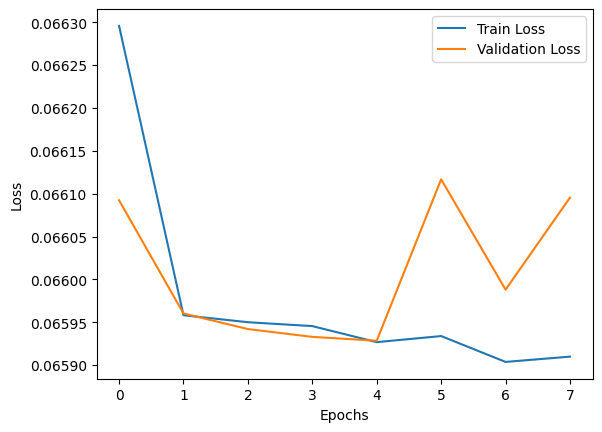

In [14]:
get_plot(history)

The model learns well until the four epoch, then begins not to generalize more well and to overfitting.

In [15]:
X_testTIME = X_testTIME.to_numpy()
X_testTIME = X_testTIME.reshape((X_testTIME.shape[0], 1, X_testTIME.shape[1]))

X_testCHARGE = X_testCHARGE.to_numpy()
X_testCHARGE = X_testCHARGE.reshape((X_testCHARGE.shape[0], 1, X_testCHARGE.shape[1]))

y_pred_deep_lstm = model_deep_lstm.predict([X_testTIME, X_testCHARGE])

1875/1875 [==============================] - 115s 61ms/step


In [16]:
y_pred_deep_lstm = y_pred_deep_lstm.reshape((y_pred_deep_lstm.shape[0],y_pred_deep_lstm.shape[2]))
y_pre = pd.DataFrame(y_pred_deep_lstm, columns=['azimuth', 'zenith'])

angular_dist_score(y_test,y_pred_deep_lstm)

0.23589146